In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 (TITAN Xp)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)
import matplotlib.cm as cm
import matplotlib.colors as colors

import jax
import jax.numpy as jnp

from jesterTOV.eos import MetaModel_with_CSE_EOS_model, construct_family
import jesterTOV.utils as utils

In [2]:
nsat = 0.16 # nuclear saturation density in fm^-3
N_CSE = 8 # number of CSE grid points
NMAX_NSAT = 12.0 # maximum density to consider in nsat
NMAX = NMAX_NSAT * nsat # maximum density in fm^-3  
eos = MetaModel_with_CSE_EOS_model(nmax_nsat=NMAX_NSAT)

In [3]:
construct_family_lambda = lambda x: construct_family(x, ndat = 100, min_nsat = 1.0)

In [4]:
def transform_func(params: dict[str, float],
                   fixed_params: dict[str, float]) -> dict[str, float]:
    """
    Auxiliary transformation function that takes in a dict of parameters for the metamodel and speed-of-sound EOS parametrization, and returns the neutron-star family as output.
    
    The idea is that JAX will have to differentiate only with respect to the first argument `params`, and we allow to pass parameters that we do not wish to optimize in the second argument.
    """
    
    # Add any parameters that are fixed and therefore not part of the first argument.
    params.update(fixed_params)
        
    # Separate the MM and CSE parameters
    NEP = {key: value for key, value in params.items() if "_sat" in key or "_sym" in key}
    NEP["nbreak"] = params["nbreak"]
    
    ngrids = jnp.array([params[f"n_CSE_{i}"] for i in range(N_CSE)])
    cs2grids = jnp.array([params[f"cs2_CSE_{i}"] for i in range(N_CSE)])
    
    # Append the final cs2 value, which is fixed at nmax 
    ngrids = jnp.append(ngrids, jnp.array([NMAX]))
    cs2grids = jnp.append(cs2grids, jnp.array([params[f"cs2_CSE_{N_CSE}"]]))
    
    # Create the EOS, ignore mu and cs2 (final 2 outputs)
    ns, ps, hs, es, dloge_dlogps, _, _ = eos.construct_eos(NEP, ngrids, cs2grids)
    eos_tuple = (ns, ps, hs, es, dloge_dlogps)
    
    # Solve the TOV equations
    P_EOS, masses_EOS, radii_EOS, Lambdas_EOS = construct_family_lambda(eos_tuple)
    es = es / utils.MeV_fm_inv3_to_geometric
    ps = ps / utils.MeV_fm_inv3_to_geometric
    P_EOS = jnp.exp(P_EOS)/utils.MeV_fm_inv3_to_geometric
    E_EOS = utils.interp_in_logspace( P_EOS, ps, es)

    # Choose what to return here:
    return_dict = {"masses_EOS": masses_EOS, "radii_EOS": radii_EOS, "Lambdas_EOS": Lambdas_EOS, "Pressure_EOS": P_EOS, "Energy_EOS": E_EOS}
    
    return return_dict

In [5]:
# Choose for an empty dict for the fixed parameters if all are varied:
fixed_params = {}

# Choose to fix some parameters -- here, E_sat and the CSE density grid points
fixed_params["E_sat"] = -16.0
for i in range(N_CSE):
    fixed_params[f"n_CSE_{i}"] = (2.0 + (i+1)) * nsat
    
print("Fixed params are:")
for key, value in fixed_params.items():
    print(f"    {key}: {value}")

Fixed params are:
    E_sat: -16.0
    n_CSE_0: 0.48
    n_CSE_1: 0.64
    n_CSE_2: 0.8
    n_CSE_3: 0.96
    n_CSE_4: 1.12
    n_CSE_5: 1.28
    n_CSE_6: 1.44
    n_CSE_7: 1.6


In [6]:
starting_parameters = {"E_sat": -16.0, # metamodel saturation energy parameters
                       "K_sat": 200.0,
                       "Q_sat": 0.0,
                       "Z_sat": 0.0,
                       "E_sym": 32.0, # metamodel symmetry energy parameters
                       "L_sym": 40.0,
                       "K_sym": -100.0,
                       "Q_sym": 0.0,
                       "Z_sym": 0.0,
                       }

# Add the nbreak parameter
starting_parameters["nbreak"] = 1.5 * nsat

# Add some CSE parameters
for i in range(N_CSE):
    starting_parameters[f"n_CSE_{i}"] = (2.0 + (i+1)) * nsat
    starting_parameters[f"cs2_CSE_{i}"] = 0.5

# Don't forget to add the final cs2 value, which is fixed at nmax
starting_parameters[f"cs2_CSE_{N_CSE}"] = 0.5

# Remove the fixed parameters from the starting parameters:
for key, value in fixed_params.items():
    if key in starting_parameters:
        del starting_parameters[key]

# Show starting parameters to the user
print("Starting parameters are:")    
for key, value in starting_parameters.items():
    print(f"    {key}: {value}")
print(f"Optimization will be in {len(starting_parameters)} dimensional EOS space.")

Starting parameters are:
    K_sat: 200.0
    Q_sat: 0.0
    Z_sat: 0.0
    E_sym: 32.0
    L_sym: 40.0
    K_sym: -100.0
    Q_sym: 0.0
    Z_sym: 0.0
    nbreak: 0.24
    cs2_CSE_0: 0.5
    cs2_CSE_1: 0.5
    cs2_CSE_2: 0.5
    cs2_CSE_3: 0.5
    cs2_CSE_4: 0.5
    cs2_CSE_5: 0.5
    cs2_CSE_6: 0.5
    cs2_CSE_7: 0.5
    cs2_CSE_8: 0.5
Optimization will be in 18 dimensional EOS space.


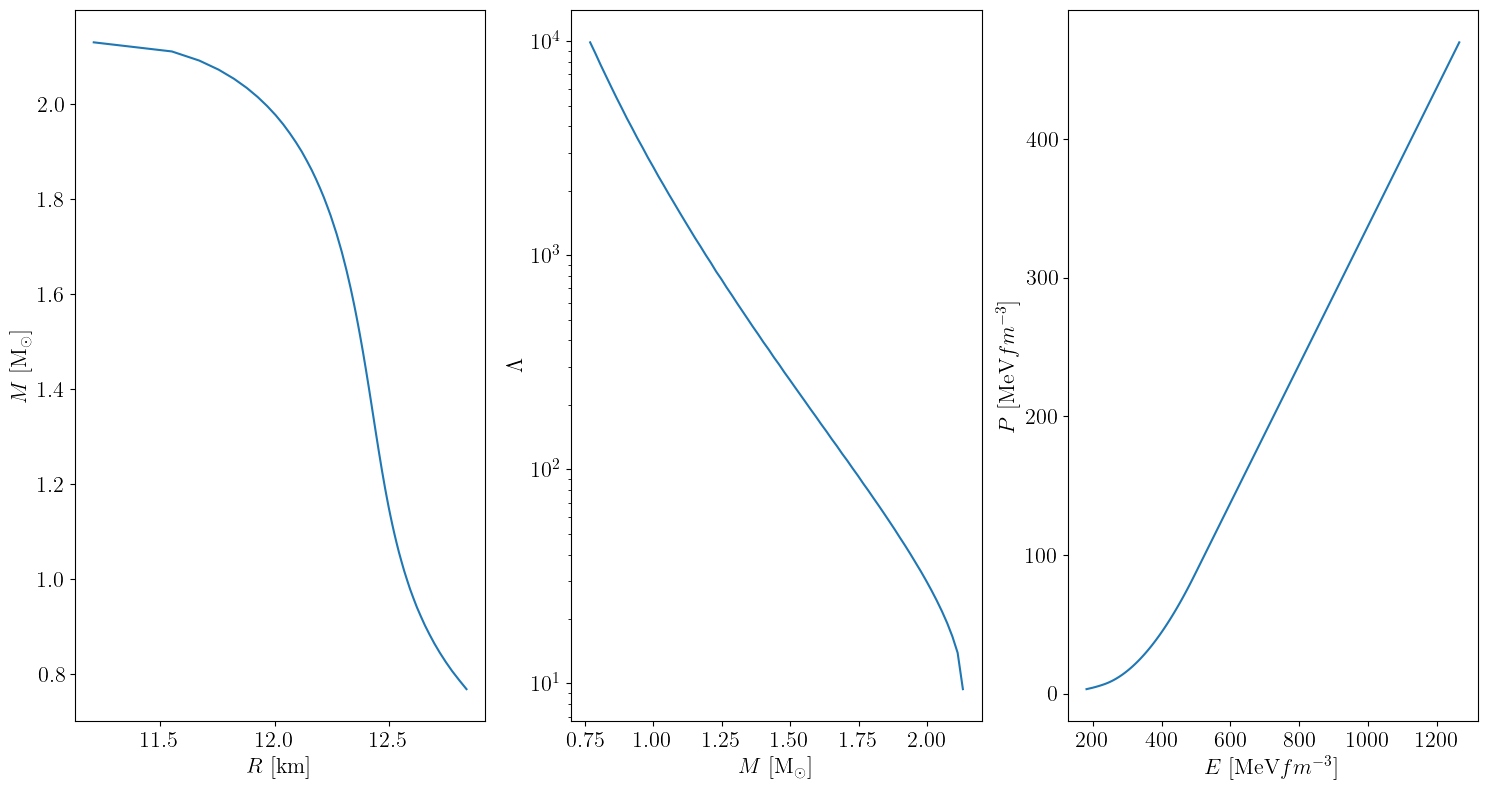

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 (TITAN Xp)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
# Solve the TOV equations
out = transform_func(starting_parameters, fixed_params)
m, r, l, pc, ec = out["masses_EOS"], out["radii_EOS"], out["Lambdas_EOS"], out["Pressure_EOS"], out["Energy_EOS"]
#print(pc,ec)
plt.subplots(nrows = 1, ncols = 3, figsize=(15, 8))
mask = m > 0.75
plt.subplot(131)
plt.plot(r[mask], m[mask])
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [M$_\odot$]")

plt.subplot(132)
plt.plot(m[mask], l[mask])
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")


plt.subplot(133)
plt.plot(ec, pc)
plt.xlabel(r"$E$ [MeV$fm^{-3}$]")
plt.ylabel(r"$P$ [MeV$fm^{-3}$]")
plt.tight_layout()
plt.show()
plt.close()

In [8]:
def score_fn_mtov(params: dict[str, float],
                  fixed_params: dict[str, float],
                  sign = -1) -> tuple:
    """
    Score function where the score is the TOV mass of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params, fixed_params)
    mtov = jnp.max(out["masses_EOS"])
    score = sign * mtov
    return score, out

def score_fn_radius(params: dict[str, float],
                    fixed_params: dict[str, float],
                    sign = +1,
                    target_radius: float = 12.0) -> tuple:
    """
    Score function where the score is the Lambda value at 1.4 Msun of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params, fixed_params)
    m, r = out["masses_EOS"], out["radii_EOS"]
    R14 = jnp.interp(1.4, m, r)
    score = sign * jnp.abs(R14 - target_radius)
    return score, out

In [8]:
try:
    import optax
    import tqdm
except ImportError:
    raise ImportError("optax and tqdm is not installed. Please install it with 'pip install optax' for this notebook.")

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 (TITAN Xp)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
def run(score_fn: Callable,
        starting_parameters: dict[str, float],
        fixed_params: dict[str, float],
        sign: int = -1, 
        nb_steps: int = 200,
        learning_rate: float = 1e-3,):
    
    print("Computing by gradient ascent . . .")
    pbar = tqdm.tqdm(range(nb_steps))
    
    # Define the score function with gradient applied to it. We only differentiate with respect to the first argument.
    score_fn_with_sign = lambda params, fixed_params: score_fn(params, fixed_params, sign)
    score_fn_with_grad = jax.jit(jax.value_and_grad(score_fn_with_sign, argnums=0, has_aux=True))
    
    # Will store the results per iteration in a dict
    trajectory = {}
    params = starting_parameters.copy()
    
    # Initialize the optimizer
    gradient_transform = optax.adam(learning_rate=learning_rate)
    opt_state = gradient_transform.init(params)
    
    for i in pbar:
        ((score, aux), grad) = score_fn_with_grad(params, fixed_params)
        m, r, l, pc, ec  = aux["masses_EOS"], aux["radii_EOS"], aux["Lambdas_EOS"], aux["Pressure_EOS"], aux["Energy_EOS"]
        
        # Check for NaNs
        if np.any(np.isnan(m)) or np.any(np.isnan(r)) or np.any(np.isnan(l)):
            print(f"Iteration {i} has NaNs. Exiting the computing loop now")
            break
        
        pbar.set_description(f"Iteration {i}: score {score}")
            
        # Apply the gradient updates to the parameters
        updates, opt_state = gradient_transform.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        
        # Enforce no CSE value is above 1 (if needed)
        for key in params.keys():
            if "cs2_CSE" in key:
                params[key] = jnp.clip(params[key], 0, 1)
                
        # Store the results:
        trajectory[i] = {"params": params,
                         "score": score,
                         "masses_EOS": aux["masses_EOS"],
                         "radii_EOS": aux["radii_EOS"],
                         "Lambdas_EOS": aux["Lambdas_EOS"],
                         "Pressure_EOS": aux["Pressure_EOS"],
                         "Energy_EOS": aux["Energy_EOS"]}
        
    return trajectory

In [10]:
def plot_trajectory(trajectory: dict,
                    plot_score: bool = False):
    """
    Plot the trajectory of the optimization process.
    """
    max_iteration = max(trajectory.keys())
    
    if plot_score:
        plt.figure(figsize=(10, 8))
        plt.plot([trajectory[i]["score"] for i in trajectory.keys()])
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.title("Trajectory of the optimization process")
        plt.show()
        plt.close()
        
    # Prepare color map based on iteration number
    iterations = list(trajectory.keys())
    norm = colors.Normalize(vmin=min(iterations), vmax=max(iterations))
    cmap = cm.viridis
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
        
    # Plot the masses and radii
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 8))
    for i in trajectory.keys():
        color = cmap(norm(i))

        # M(R)
        plt.subplot(121)
        mask = trajectory[i]["masses_EOS"] > 0.75
        plt.plot(trajectory[i]["radii_EOS"][mask], trajectory[i]["masses_EOS"][mask], color=color)
        
        # Lambda(M)
        plt.subplot(122)
        plt.plot(trajectory[i]["masses_EOS"][mask], trajectory[i]["Lambdas_EOS"][mask], color=color)
      
    plt.subplot(121)
    plt.xlabel(r"$R$ [km]")
    plt.ylabel(r"$M$ [M$_\odot$]")
    
    plt.subplot(122)
    plt.xlabel(r"$M$ [M$_\odot$]")
    plt.ylabel(r"$\Lambda$")
    plt.yscale("log")
    plt.tight_layout()
    
    fig.colorbar(sm, ax=axes.ravel().tolist(), label="Iteration")

Computing by gradient ascent . . .


Iteration 99: score -2.442975153105854: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


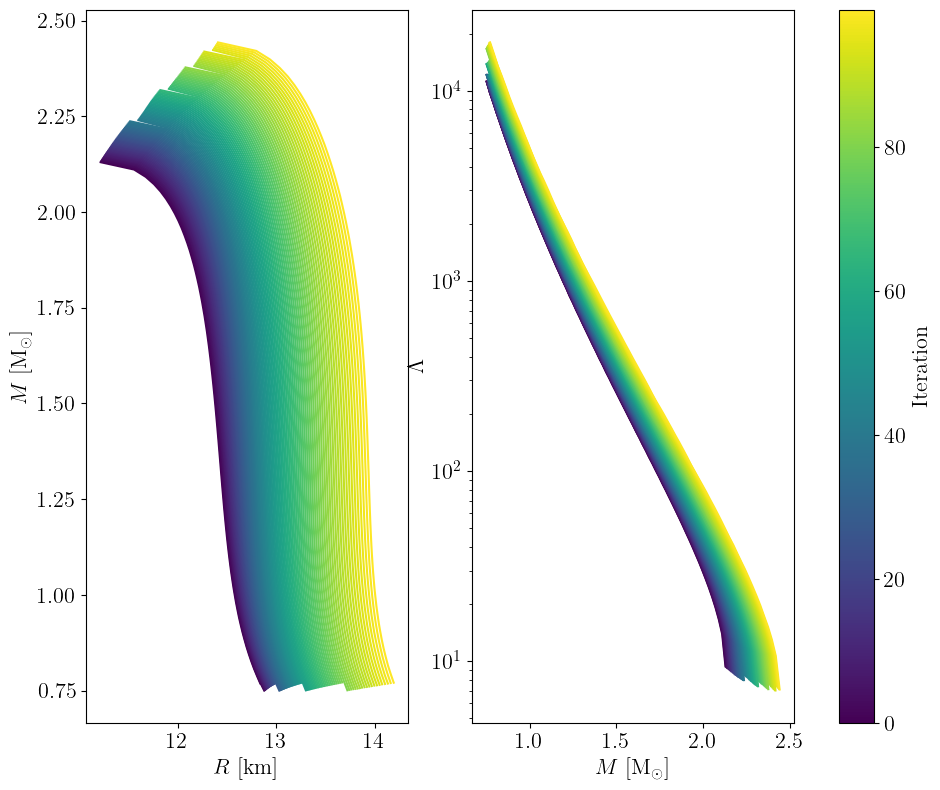

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 (TITAN Xp)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
trajectory = run(score_fn_mtov,
                 starting_parameters,
                 fixed_params,
                 sign = -1,
                 nb_steps = 100,
                 learning_rate = 1e-3)
plot_trajectory(trajectory)
plt.show()
plt.close()

# Creating Mock data

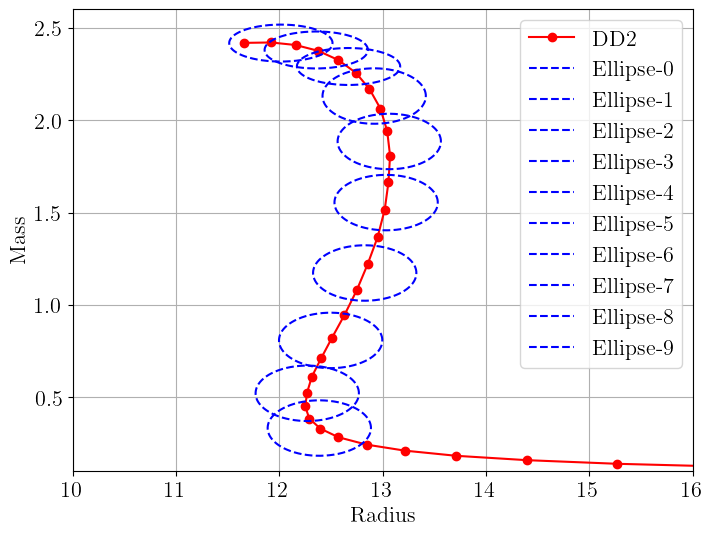

In [11]:
import numpy as np
import matplotlib.pyplot as plt
e1, p1, M1, R1 = np.loadtxt('mr_dd2p.out', usecols=(0, 1, 2, 3), unpack=True)

# Center of the ellipse
center_x0, center_y0 = 12.014942, 2.417554  
center_x1, center_y1 = 12.357403, 2.380231  
center_x2, center_y2 = 12.669880, 2.290879  
center_x3, center_y3 = 12.917999, 2.130977
center_x4, center_y4 = 13.063961, 1.885110  
center_x5, center_y5 = 13.033545, 1.554428  
center_x6, center_y6 = 12.826422, 1.173393 
center_x7, center_y7 = 12.496814, 0.808577  
center_x8, center_y8 = 12.270296, 0.522443  
center_x9, center_y9 = 12.386972, 0.334385   

# Asymmetric distances from center along x-axis
a_min0 = 0.5  # Minimum distance (left side)
a_max0 = 0.5  # Maximum distance (right side)
a_min1 = 0.5
a_max1 = 0.5
a_min2 = 0.5
a_max2 = 0.5
a_min3 = 0.5  # Minimum distance (left side)
a_max3 = 0.5  # Maximum distance (right side)
a_min4 = 0.5
a_max4 = 0.5
a_min5 = 0.5
a_max5 = 0.5
a_min6 = 0.5
a_max6 = 0.5
a_min7 = 0.5
a_max7 = 0.5
a_min8 = 0.5
a_max8 = 0.5
a_min9 = 0.5
a_max9 = 0.5

# Semi-major axis (average of min and max)
a_avg0 = (a_min0 + a_max0) / 2
a_avg1 = (a_min1 + a_max1) / 2
a_avg2 = (a_min2 + a_max2) / 2
a_avg3 = (a_min3 + a_max3) / 2
a_avg4 = (a_min4 + a_max4) / 2
a_avg5 = (a_min5 + a_max5) / 2
a_avg6 = (a_min6 + a_max6) / 2
a_avg7 = (a_min7 + a_max7) / 2
a_avg8 = (a_min8 + a_max8) / 2
a_avg9 = (a_min9 + a_max9) / 2

# Shift the center to make it asymmetric
# New "parametric center" (not the geometric center)
parametric_center_x0 = center_x0 + (a_max0 - a_min0) / 2
parametric_center_x1 = center_x1 + (a_max1 - a_min1) / 2
parametric_center_x2 = center_x2 + (a_max2 - a_min2) / 2
parametric_center_x3 = center_x3 + (a_max3 - a_min3) / 2
parametric_center_x4 = center_x4 + (a_max4 - a_min4) / 2
parametric_center_x5 = center_x5 + (a_max5 - a_min5) / 2
parametric_center_x6 = center_x6 + (a_max6 - a_min6) / 2
parametric_center_x7 = center_x7 + (a_max7 - a_min7) / 2
parametric_center_x8 = center_x8 + (a_max8 - a_min8) / 2
parametric_center_x9 = center_x9 + (a_max9 - a_min9) / 2



# Semi-minor axis (y-axis remains symmetric)
b = 0.15  # y-axis width = 0.5 (so ±0.5 from center)

# Generate 500 points
theta = np.linspace(0, 2 * np.pi, 500)

# Parametric equations (shifted to create asymmetry)
x0 = parametric_center_x0 + a_avg0 * np.cos(theta)
x1 = parametric_center_x1 + a_avg1 * np.cos(theta)
x2 = parametric_center_x2 + a_avg2 * np.cos(theta)
x3 = parametric_center_x3 + a_avg3 * np.cos(theta)
x4 = parametric_center_x4 + a_avg4 * np.cos(theta)
x5 = parametric_center_x5 + a_avg5 * np.cos(theta)
x6 = parametric_center_x6 + a_avg6 * np.cos(theta)
x7 = parametric_center_x7 + a_avg7 * np.cos(theta)
x8 = parametric_center_x8 + a_avg8 * np.cos(theta)
x9 = parametric_center_x9 + a_avg9 * np.cos(theta)

y0 = center_y0 + 0.1 * np.sin(theta)
y1 = center_y1 + 0.1 * np.sin(theta)
y2 = center_y2 + 0.1 * np.sin(theta)
y3 = center_y3 + b * np.sin(theta)
y4 = center_y4 + b * np.sin(theta)
y5 = center_y5 + b * np.sin(theta)
y6 = center_y6 + b * np.sin(theta)
y7 = center_y7 + b * np.sin(theta)
y8 = center_y8 + b * np.sin(theta)
y9 = center_y9 + b * np.sin(theta)
# Plot the ellipse
plt.figure(figsize=(8, 6))
plt.plot(R1,M1, "ro-",label='DD2')
plt.plot(x0, y0, 'b--', label='Ellipse-0')
plt.plot(x1, y1, 'b--', label='Ellipse-1')
plt.plot(x2, y2, 'b--', label='Ellipse-2')
plt.plot(x3, y3, 'b--', label='Ellipse-3')
plt.plot(x4, y4, 'b--', label='Ellipse-4')
plt.plot(x5, y5, 'b--', label='Ellipse-5')
plt.plot(x6, y6, 'b--', label='Ellipse-6')
plt.plot(x7, y7, 'b--', label='Ellipse-7')
plt.plot(x8, y8, 'b--', label='Ellipse-8')
plt.plot(x9, y9, 'b--', label='Ellipse-9')
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.xlim(10,16)
plt.ylim(0.1,2.6)
plt.legend()
plt.grid(True)
plt.show()


# Creating Likelihoods

In [12]:

import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.stats import norm
import numpy as np

# Convert your data to JAX arrays (only do this once)
x0p,y0p = jnp.array(x0), jnp.array(y0)
x1p,y1p = jnp.array(x1), jnp.array(y1)
x2p,y2p = jnp.array(x2), jnp.array(y2)
x3p,y3p = jnp.array(x3), jnp.array(y3)
x4p,y4p = jnp.array(x4), jnp.array(y4)
x5p,y5p = jnp.array(x5), jnp.array(y5)
x6p,y6p = jnp.array(x6), jnp.array(y6)
x7p,y7p = jnp.array(x7), jnp.array(y7)
x8p,y8p = jnp.array(x8), jnp.array(y8)
x9p,y9p = jnp.array(x9), jnp.array(y9)



# Compute bandwidths (Silverman's rule of thumb)
def silverman_bandwidth(data):
    n = len(data)
    iqr = jnp.percentile(data, 75) - jnp.percentile(data, 25)
    h = 0.9 * jnp.minimum(jnp.std(data), iqr/1.34) * n**(-1/5)
    return h

bw_x0, bw_y0 = silverman_bandwidth(x0p), silverman_bandwidth(y0p)
bw_x1, bw_y1 = silverman_bandwidth(x1p), silverman_bandwidth(y1p)
bw_x2, bw_y2 = silverman_bandwidth(x2p), silverman_bandwidth(y2p)
bw_x3, bw_y3 = silverman_bandwidth(x3p), silverman_bandwidth(y3p)
bw_x4, bw_y4 = silverman_bandwidth(x4p), silverman_bandwidth(y4p)
bw_x5, bw_y5 = silverman_bandwidth(x5p), silverman_bandwidth(y5p)
bw_x6, bw_y6 = silverman_bandwidth(x6p), silverman_bandwidth(y6p)
bw_x7, bw_y7 = silverman_bandwidth(x7p), silverman_bandwidth(y7p)
bw_x8, bw_y8 = silverman_bandwidth(x8p), silverman_bandwidth(y8p)
bw_x9, bw_y9 = silverman_bandwidth(x9p), silverman_bandwidth(y9p)


# JAX-compatible KDE using your exact data points
def kde_2d_jax(x, y, samples_x, samples_y, bw_x, bw_y):
    """2D KDE using JAX operations only"""
    def single_point_kde(x_p, y_p):
        # Product of 1D KDEs (simplified 2D KDE)
        kde_x = norm.pdf(x_p, loc=samples_x, scale=bw_x).mean()
        kde_y = norm.pdf(y_p, loc=samples_y, scale=bw_y).mean()
        return kde_x * kde_y
    
    # Vectorize over input points
    return vmap(single_point_kde)(x, y)

# Likelihood functions using only your data
@jit
def likelihood_xy0(R, M):
    return kde_2d_jax(R, M, x0p, y0p, bw_x0, bw_y0)
@jit
def likelihood_xy1(R, M):
    return kde_2d_jax(R, M, x1p, y1p, bw_x1, bw_y1)
@jit
def likelihood_xy2(R, M):
    return kde_2d_jax(R, M, x2p, y2p, bw_x2, bw_y2)
@jit
def likelihood_xy3(R, M):
    return kde_2d_jax(R, M, x3p, y3p, bw_x3, bw_y3)
@jit
def likelihood_xy4(R, M):
    return kde_2d_jax(R, M, x4p, y4p, bw_x4, bw_y4)
@jit
def likelihood_xy5(R, M):
    return kde_2d_jax(R, M, x5p, y5p, bw_x5, bw_y5)
@jit
def likelihood_xy6(R, M):
    return kde_2d_jax(R, M, x6p, y6p, bw_x6, bw_y6)
@jit
def likelihood_xy7(R, M):
    return kde_2d_jax(R, M, x7p, y7p, bw_x7, bw_y7)
@jit
def likelihood_xy8(R, M):
    return kde_2d_jax(R, M, x8p, y8p, bw_x8, bw_y8)
@jit
def likelihood_xy9(R, M):
    return kde_2d_jax(R, M, x9p, y9p, bw_x9, bw_y9)

# Score Function with fixed Masses

In [12]:
def score_fn_fixed_mass(params: dict[str, float],
                  fixed_params: dict[str, float],
                  sign = -1) -> tuple:
    """
    Score function where the score is based on the likelihood of radius and mass predictions.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Returns:
        tuple: (score, output_dict) where output_dict contains the TOV solution results
    """
    
    # Get the TOV solution results
    out = transform_func(params, fixed_params)
    masses = out["masses_EOS"]
    radii = out["radii_EOS"]
    
    # We need to predict R1 at M1 for each likelihood function
    # Here we'll use interpolation to get radius predictions at specific masses
    # You may need to adjust this depending on your exact needs
    
    # For demonstration, I'll assume we have some target masses M1_pred where we want to evaluate radii
    # You'll need to replace this with your actual target masses
    M1_pred = jnp.array([1.0,1.2,1.4, 1.6, 1.8, 2.0])  # Example target masses - replace with your actual values
    
    # Interpolate to get radii at these target masses
    R1_pred = jnp.interp(M1_pred, masses, radii)
    
    # Stabilized likelihood calculation
    lkhds = [
        jnp.maximum(likelihood_xy0(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy1(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy2(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy3(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy4(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy5(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy6(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy7(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy8(R1_pred, M1_pred), 1e-100),
        jnp.maximum(likelihood_xy9(R1_pred, M1_pred), 1e-100)
    ]
    
    # Numerically stable weighted log-likelihood calculation
    log_lkhd = sum(jnp.mean(-jnp.log(lkhd + 1e-100)) for lkhd in lkhds)
    normalized_log_lkhd = log_lkhd / 10 
    total_loss = normalized_log_lkhd 
    
    # Apply the sign to determine optimization direction
    score = sign * total_loss
    
    return score, out

# Score function with whole Mass-Radius

In [13]:
def score_fn_full_MR(params: dict[str, float],
                 fixed_params: dict[str, float],
                 sign = -1) -> tuple:
    """
    Score function evaluating how well the entire mass-radius curve fits
    within all likelihood distributions.
    
    For each point on our M-R curve, we evaluate its probability under
    each likelihood distribution, then aggregate these probabilities.
    """
    
    # Get the TOV solution results
    out = transform_func(params, fixed_params)
    masses = out["masses_EOS"]  # Array of masses [M⊙]
    radii = out["radii_EOS"]    # Corresponding radii [km]
    
    # Initialize total log likelihood
    total_log_lkhd = 0.0
    
    # Evaluate against each likelihood distribution
    likelihood_fns = [
        likelihood_xy0, likelihood_xy1, likelihood_xy2,
        likelihood_xy3, likelihood_xy4, likelihood_xy5,
        likelihood_xy6
    ] #, likelihood_xy7, likelihood_xy8, likelihood_xy9
    
    for likelihood_fn in likelihood_fns:
        # Vectorized evaluation of all M-R points against this distribution
        point_lkhds = jnp.maximum(likelihood_fn(radii, masses), 1e-100)
        log_lkhds = -jnp.log(point_lkhds)
        
        # Take the best-fitting point (most conservative approach)
        # Alternatively could use mean or other aggregation
        best_fit = jnp.min(log_lkhds)
        total_log_lkhd += best_fit
    
    # Normalize by number of distributions
    normalized_score = total_log_lkhd / len(likelihood_fns)
    
    # Apply optimization direction
    score = sign * normalized_score
    
    return score, out

# Plots with iteration

In [14]:
def plot_trajectory(trajectory: dict,
                    plot_score: bool = False):
    """
    Plot the trajectory of the optimization process.
    """
    max_iteration = max(trajectory.keys())
    
    if plot_score:
        plt.figure(figsize=(10, 8))
        plt.plot([trajectory[i]["score"] for i in trajectory.keys()])
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.title("Trajectory of the optimization process")
        plt.show()
        plt.close()
        
    # Prepare color map based on iteration number
    iterations = list(trajectory.keys())
    norm = colors.Normalize(vmin=min(iterations), vmax=max(iterations))
    cmap = cm.viridis
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
        
    # Plot the masses and radii
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 8))
    for i in trajectory.keys():
        color = cmap(norm(i))

        # M(R)
        plt.subplot(131)
        mask = trajectory[i]["masses_EOS"] > 0.75
        plt.plot(trajectory[i]["radii_EOS"][mask], trajectory[i]["masses_EOS"][mask], color=color)
        
        # Lambda(M)
        plt.subplot(132)
        plt.plot(trajectory[i]["masses_EOS"][mask], trajectory[i]["Lambdas_EOS"][mask], color=color)

        # pressure(E)
        plt.subplot(133)
        plt.plot(trajectory[i]["Energy_EOS"], trajectory[i]["Pressure_EOS"], color=color)
    
    mask = M1 > 0.75
    plt.subplot(131)
    plt.plot(x0, y0, color="purple", lw=2, label='Likelihood')
    plt.plot(x1, y1, color="purple", lw=2)
    plt.plot(x2, y2, color="purple", lw=2)
    plt.plot(x3, y3, color="purple", lw=2)
    plt.plot(x4, y4, color="purple", lw=2)
    plt.plot(x5, y5, color="purple", lw=2)
    plt.plot(x6, y6, color="purple", lw=2)
    #plt.plot(x7, y7, color="purple", lw=2)
    #plt.plot(x8, y8, color="purple", lw=2)
    #plt.plot(x9, y9, color="purple", lw=2)
    plt.plot(R1[mask][:-1], M1[mask][:-1], color="red", lw=2, label='Target')
    plt.xlabel(r"$R$ [km]")
    plt.ylabel(r"$M$ [M$_\odot$]")
    plt.legend()

    
    plt.subplot(132)
    plt.xlabel(r"$M$ [M$_\odot$]")
    plt.ylabel(r"$\Lambda$")
    plt.yscale("log")
    
    plt.subplot(133)
    plt.plot(e1[mask][:-1], p1[mask][:-1], color="red", lw=2, label='Target')
    plt.xlabel(r"$E$ [MeV$fm^{-3}$]")
    plt.ylabel(r"$P$ [MeV$fm^{-3}$]")
    plt.legend()
    plt.tight_layout()
    
    fig.colorbar(sm, ax=axes.ravel().tolist(), label="Iteration")

Computing by gradient ascent . . .


Iteration 5999: score -1.2457113938887738: 100%|██████████| 6000/6000 [1:52:55<00:00,  1.13s/it]  
/home/naresh/.conda/envs/neutron/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


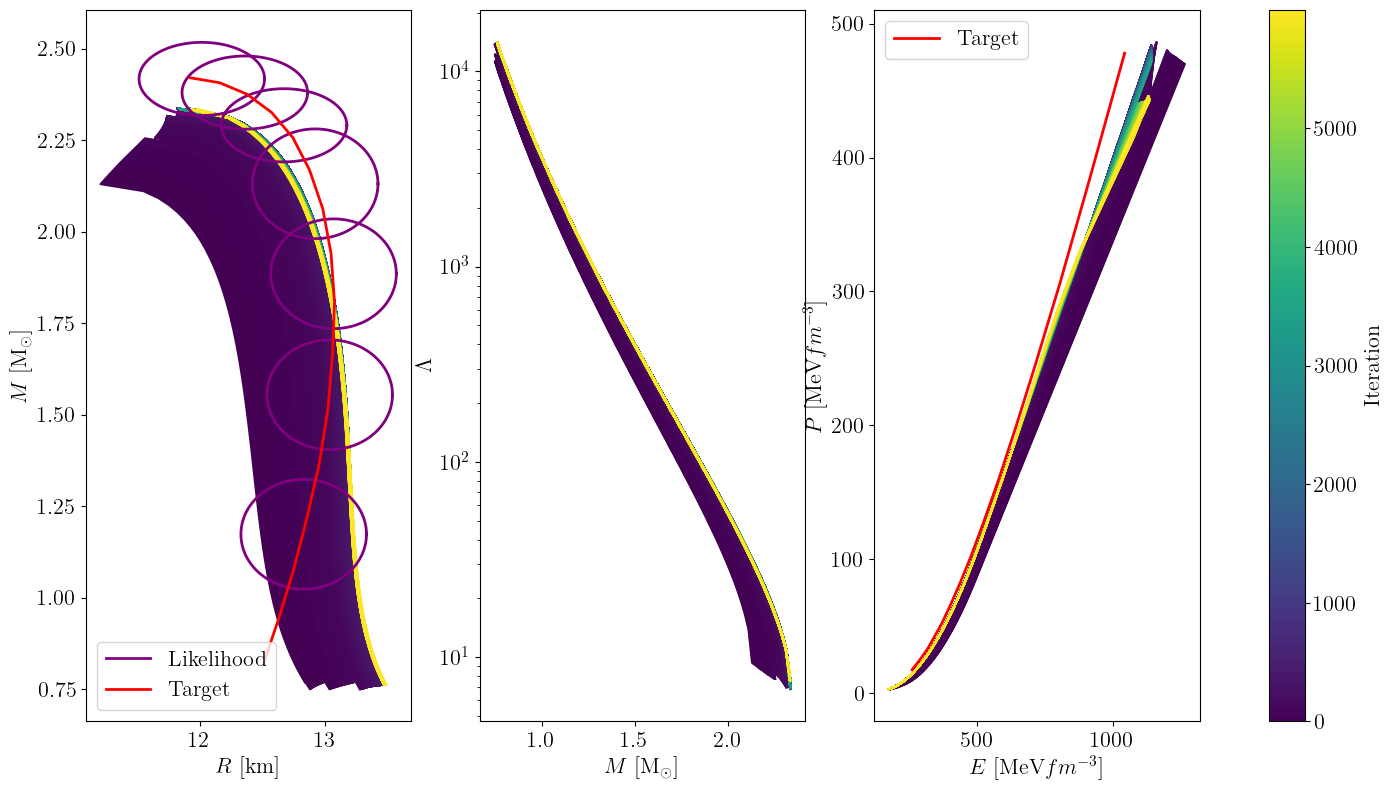

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1 (TITAN Xp)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
trajectory = run(score_fn_full_MR,
                 starting_parameters,
                 fixed_params,
                 sign = 1,
                 nb_steps = 6000,
                 learning_rate = 1e-3)
plot_trajectory(trajectory)
plt.show()
plt.close()